In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from scipy.stats import mode

# Load dataset
data = pd.read_csv("mood_music_dataset.csv")

# Quick check
print(data.head())
print("\nMissing values per column:\n", data.isna().sum())

# Fill missing values
data["Heart Rate"].fillna(data["Heart Rate"].mode()[0], inplace=True)
data["Skin Temperature"].fillna(data["Skin Temperature"].median(), inplace=True)
data["Blink Rate"].fillna(data["Blink Rate"].mode()[0], inplace=True)

print("Missing values after fill:\n", data.isna().sum())


   Heart Rate  Skin Temperature  Blink Rate Time of Day      Mood      Score
0   72.849293         36.722123   19.032228       Night     Happy   8.003257
1   69.546081         35.626662   11.634197     Morning       Sad  24.232981
2   97.983918         38.022626   34.686636   Afternoon  Stressed  77.367935
3   72.682425         36.717484   20.984903     Evening     Happy  52.868585
4   70.316874         35.949165   10.210935   Afternoon       Sad  92.796906

Missing values per column:
 Heart Rate          74
Skin Temperature    75
Blink Rate          75
Time of Day          0
Mood                 0
Score                0
dtype: int64
Missing values after fill:
 Heart Rate          0
Skin Temperature    0
Blink Rate          0
Time of Day         0
Mood                0
Score               0
dtype: int64


C:\Users\C Sutharsan\AppData\Local\Temp\ipykernel_9036\464552926.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Heart Rate"].fillna(data["Heart Rate"].mode()[0], inplace=True)
C:\Users\C Sutharsan\AppData\Local\Temp\ipykernel_9036\464552926.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [2]:
def detect_and_print_outliers(df, cols):
    for col in cols:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)][[col]]
        print(f"\nColumn: {col}")
        print("Lower bound:", lower, "Upper bound:", upper)
        print(f"Outlier Count: {outliers.shape[0]}")
        if not outliers.empty:
            print(outliers.head())

numeric_cols = ["Heart Rate", "Skin Temperature", "Blink Rate", "Score"]
detect_and_print_outliers(data, numeric_cols)


Column: Heart Rate
Lower bound: 38.89034178607855 Upper bound: 117.1934641313704
Outlier Count: 3
     Heart Rate
601  121.846742
769  125.619470
888  119.100486

Column: Skin Temperature
Lower bound: 35.07186626523236 Upper bound: 38.25516361050248
Outlier Count: 23
     Skin Temperature
143         38.475571
192         38.882990
196         38.639201
253         38.283898
307         38.367416

Column: Blink Rate
Lower bound: -5.1486700888289025 Upper bound: 44.38026291957972
Outlier Count: 85
    Blink Rate
10   49.493592
13   49.493592
23   49.493592
30   49.493592
63   49.493592

Column: Score
Lower bound: -52.652694420715406 Upper bound: 151.24838787320638
Outlier Count: 0


In [3]:
# Handle outliers directly in the original dataframe
def handle_outliers_inplace(df):
    # Heart Rate -> Cap
    Q1, Q3 = df["Heart Rate"].quantile(0.25), df["Heart Rate"].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5*IQR
    df["Heart Rate"] = df["Heart Rate"].clip(upper=upper)

    # Skin Temperature -> Cap
    Q1, Q3 = df["Skin Temperature"].quantile(0.25), df["Skin Temperature"].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5*IQR
    df["Skin Temperature"] = df["Skin Temperature"].clip(upper=upper)

    # Blink Rate -> Remove artifact rows
    Q1, Q3 = df["Blink Rate"].quantile(0.25), df["Blink Rate"].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df.drop(df[(df["Blink Rate"] < lower) | (df["Blink Rate"] > upper)].index, inplace=True)

# Apply cleaning directly
handle_outliers_inplace(data)


In [4]:
#Feature engineering
# Categorize heart rate
def categorize_heart_rate(hr):
    if hr < 60:
        return "Low"
    elif 60 <= hr <= 100:
        return "Medium"
    return "High"

# Categorize blink rate
def categorize_blink_rate(br):
    return "High" if br > 25 else "Good"

# Apply
data["Heart_rate_category"] = data["Heart Rate"].map(categorize_heart_rate)
data["Blink_rate_category"] = data["Blink Rate"].map(categorize_blink_rate)


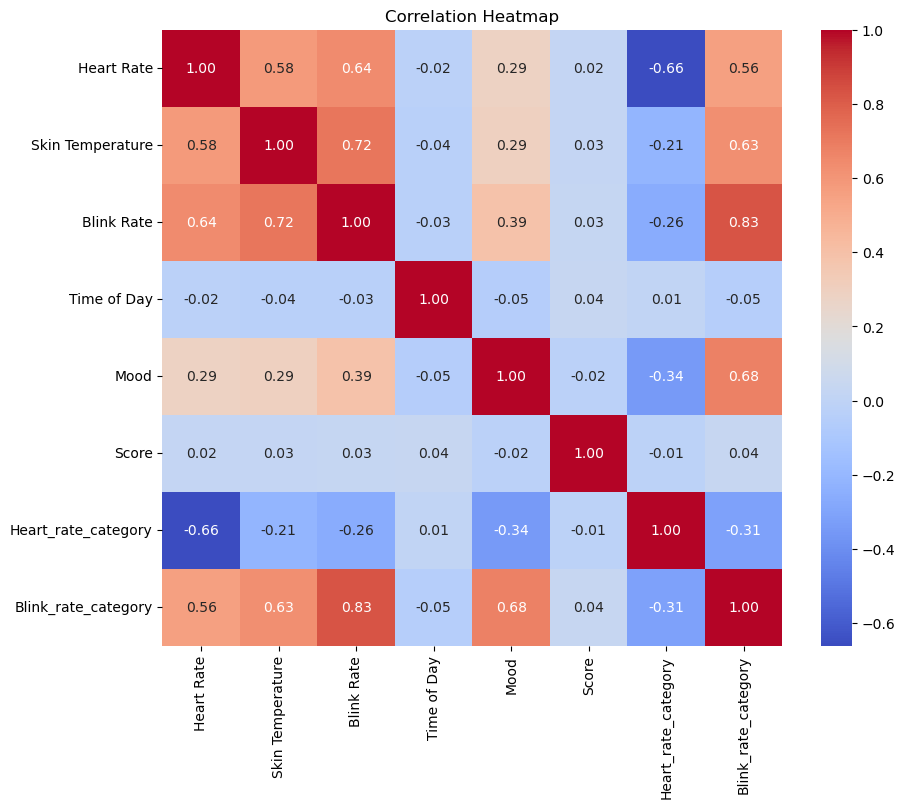

In [5]:
# Encode categorical columns
categorical_cols = ["Time of Day", "Mood", "Heart_rate_category", "Blink_rate_category"]

mood_encoder = LabelEncoder()
data["Mood"] = mood_encoder.fit_transform(data["Mood"])

# Save encoder for later
joblib.dump(mood_encoder, "mood_encoder.pkl")

# Encode other categorical cols
for col in [c for c in categorical_cols if c != "Mood"]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.savefig("correlation.png")


In [6]:
# Drop unused columns
X = data.drop(["Mood", "Heart_rate_category", "Blink_rate_category"], axis=1)
y = data["Mood"]

# Round off float columns to 1 decimal place
float_cols = X.select_dtypes(include=["float"]).columns
X[float_cols] = X[float_cols].round(1)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# XGBoost model
model = XGBClassifier(n_estimators=1000, random_state=42, eval_metric="mlogloss")

pipe = Pipeline([("model", model)])
pipe.fit(X_train, y_train)

# Save trained model
joblib.dump(pipe, "XGBoost_advanced_classifier.pkl")

# Predictions
preds = pipe.predict(X_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, preds))
print("Precision (macro):", precision_score(y_test, preds, average="macro"))
print("Recall (macro):", recall_score(y_test, preds, average="macro"))
print("F1 Score (macro):", f1_score(y_test, preds, average="macro"))

print("\nClassification Report:\n", classification_report(y_test, preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
X

Train shape: (1132, 5) Test shape: (283, 5)
Accuracy: 0.8833922261484098
Precision (macro): 0.884784618117429
Recall (macro): 0.8835010060362174
F1 Score (macro): 0.8834396168539359

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92        70
           1       0.79      0.85      0.82        71
           2       0.88      0.80      0.84        71
           3       0.95      0.97      0.96        71

    accuracy                           0.88       283
   macro avg       0.88      0.88      0.88       283
weighted avg       0.88      0.88      0.88       283

Confusion Matrix:
 [[64  2  0  4]
 [ 3 60  8  0]
 [ 0 14 57  0]
 [ 2  0  0 69]]


,Heart Rate,Skin Temperature,Blink Rate,Time of Day,Score
0,72.8,36.7,19.0,3,8.0
1,69.5,35.6,11.6,2,24.2
2,98.0,38.0,34.7,0,77.4
3,72.7,36.7,21.0,1,52.9
4,70.3,35.9,10.2,0,92.8
...,...,...,...,...,...
1495,75.9,37.1,23.8,0,92.8
1496,111.3,37.2,27.0,1,9.4
1497,62.1,35.7,8.5,1,37.1
1498,84.5,36.2,21.3,0,70.9


In [7]:
import joblib
import numpy as np

try:
    model = joblib.load("XGBoost_advanced_classifier.pkl")
    mood_encoder = joblib.load("mood_encoder.pkl")
except FileNotFoundError as e:
    print(f"Error: Could not load required file. Please ensure {e.filename} is in the correct path.")
    # Exiting here as the rest of the script can't run without the model/encoder
    exit()


# Automatically align dictionary with encoder classes
# Note: This assumes the encoder has exactly 4 classes, which matches the list size.
mood_to_song = {
    mood: song for mood, song in zip(
        mood_encoder.classes_,
        ["Anirudh songs 🎉",
         "Calm Acoustic or Soft Piano U1 drugs 🎶",
         "Healing music Endrendrum Raja 🤘",
         "Lo-fi or Jazz to chill out Periya Bhai ☕"]
    )
}

# Time encoding
time_mapping = {"Morning": 0, "Afternoon": 1, "Evening": 2, "Night": 3}

# User input
print("Enter the following details to predict your mood:")

# Using a try/except block for better error handling on float inputs
try:
    heart_rate = float(input("💓 Heart Rate (bpm): "))
    blink_rate = float(input("👀 Blink Rate (per min): "))
    temperature = float(input("🌡️ Body Temperature (°C): "))
    score = float(input("⭐ Score (0-100): "))
except ValueError:
    print("Invalid input. Heart Rate, Blink Rate, Temperature, and Score must be numbers.")
    exit()

time_input = input("⏰ Time of Day (Morning/Afternoon/Evening/Night): ")

time_of_day = time_mapping.get(time_input.capitalize(), 0)

# Features - use a list of lists for a single sample prediction, as expected by many models
features = np.array([[heart_rate, blink_rate, temperature, score, time_of_day]])

# Predict
pred_numeric = model.predict(features)[0]
pred_label = mood_encoder.inverse_transform([pred_numeric])[0]

# Song recommendation
song_suggestion = mood_to_song.get(pred_label, "Any genre you enjoy 🎵")

print("\n==============================")
print(f"Predicted Mood: {pred_label}")
print(f"Recommended Songs: {song_suggestion}")
print("==============================")

Enter the following details to predict your mood:


💓 Heart Rate (bpm):  72
👀 Blink Rate (per min):  30
🌡️ Body Temperature (°C):  40
⭐ Score (0-100):  90
⏰ Time of Day (Morning/Afternoon/Evening/Night):  Night



Predicted Mood: Stressed
Recommended Songs: Lo-fi or Jazz to chill out Periya Bhai ☕


1. PAIRWISE RELATIONSHIPS WITH SCORE


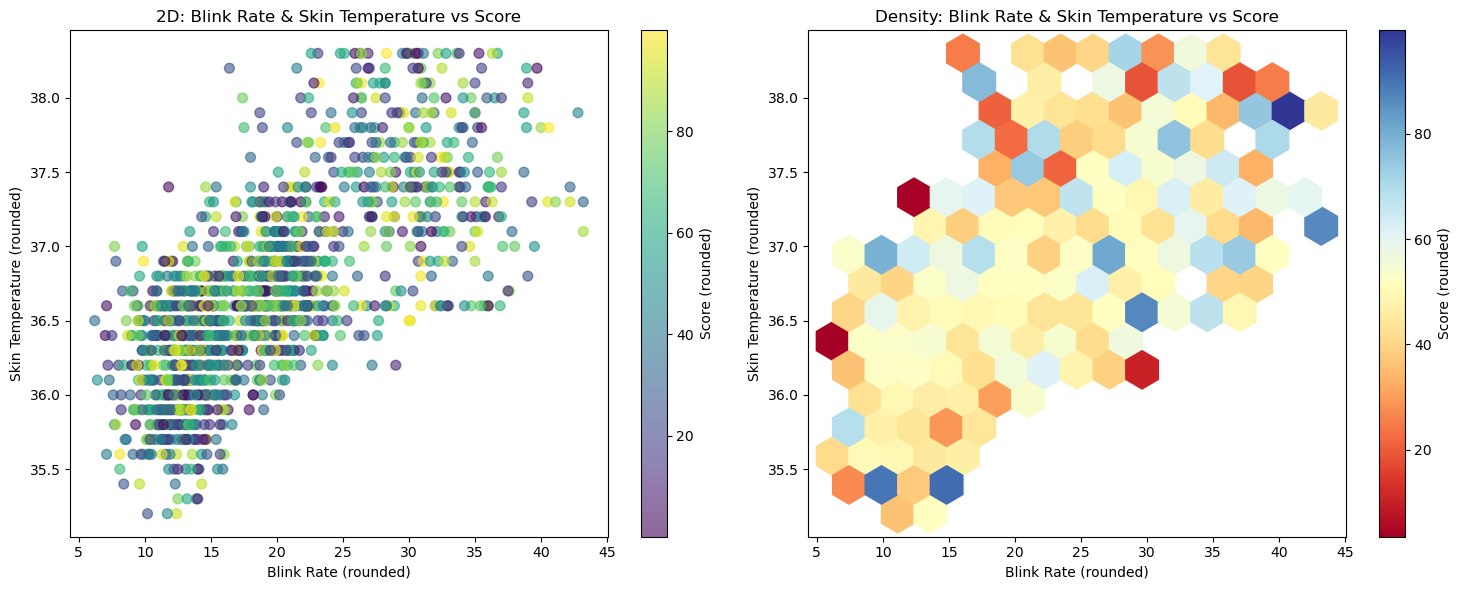

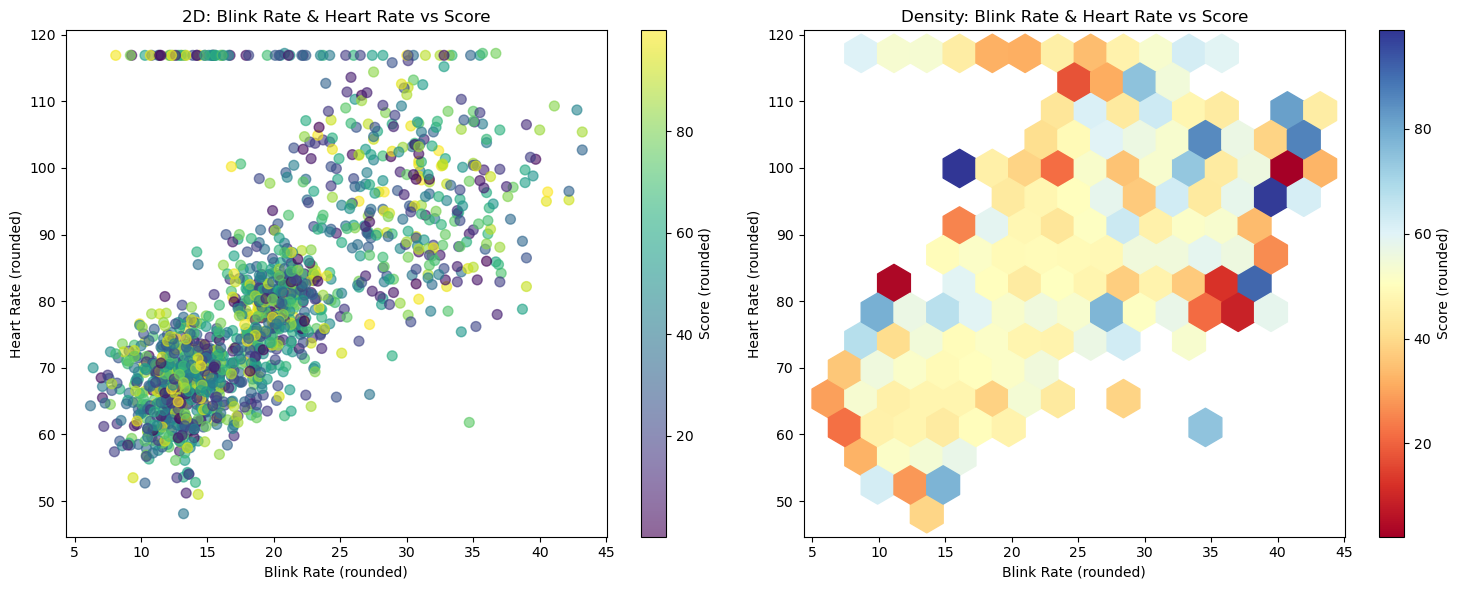

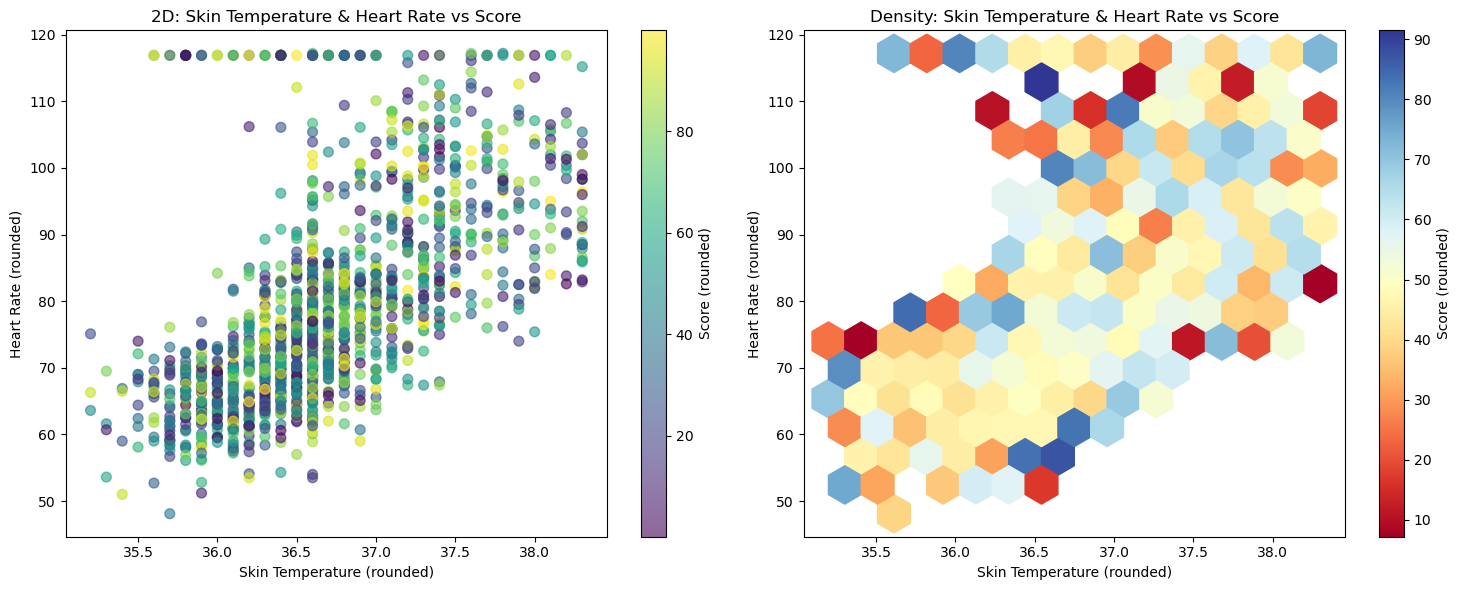


2. TRIPLE RELATIONSHIPS WITH SCORE


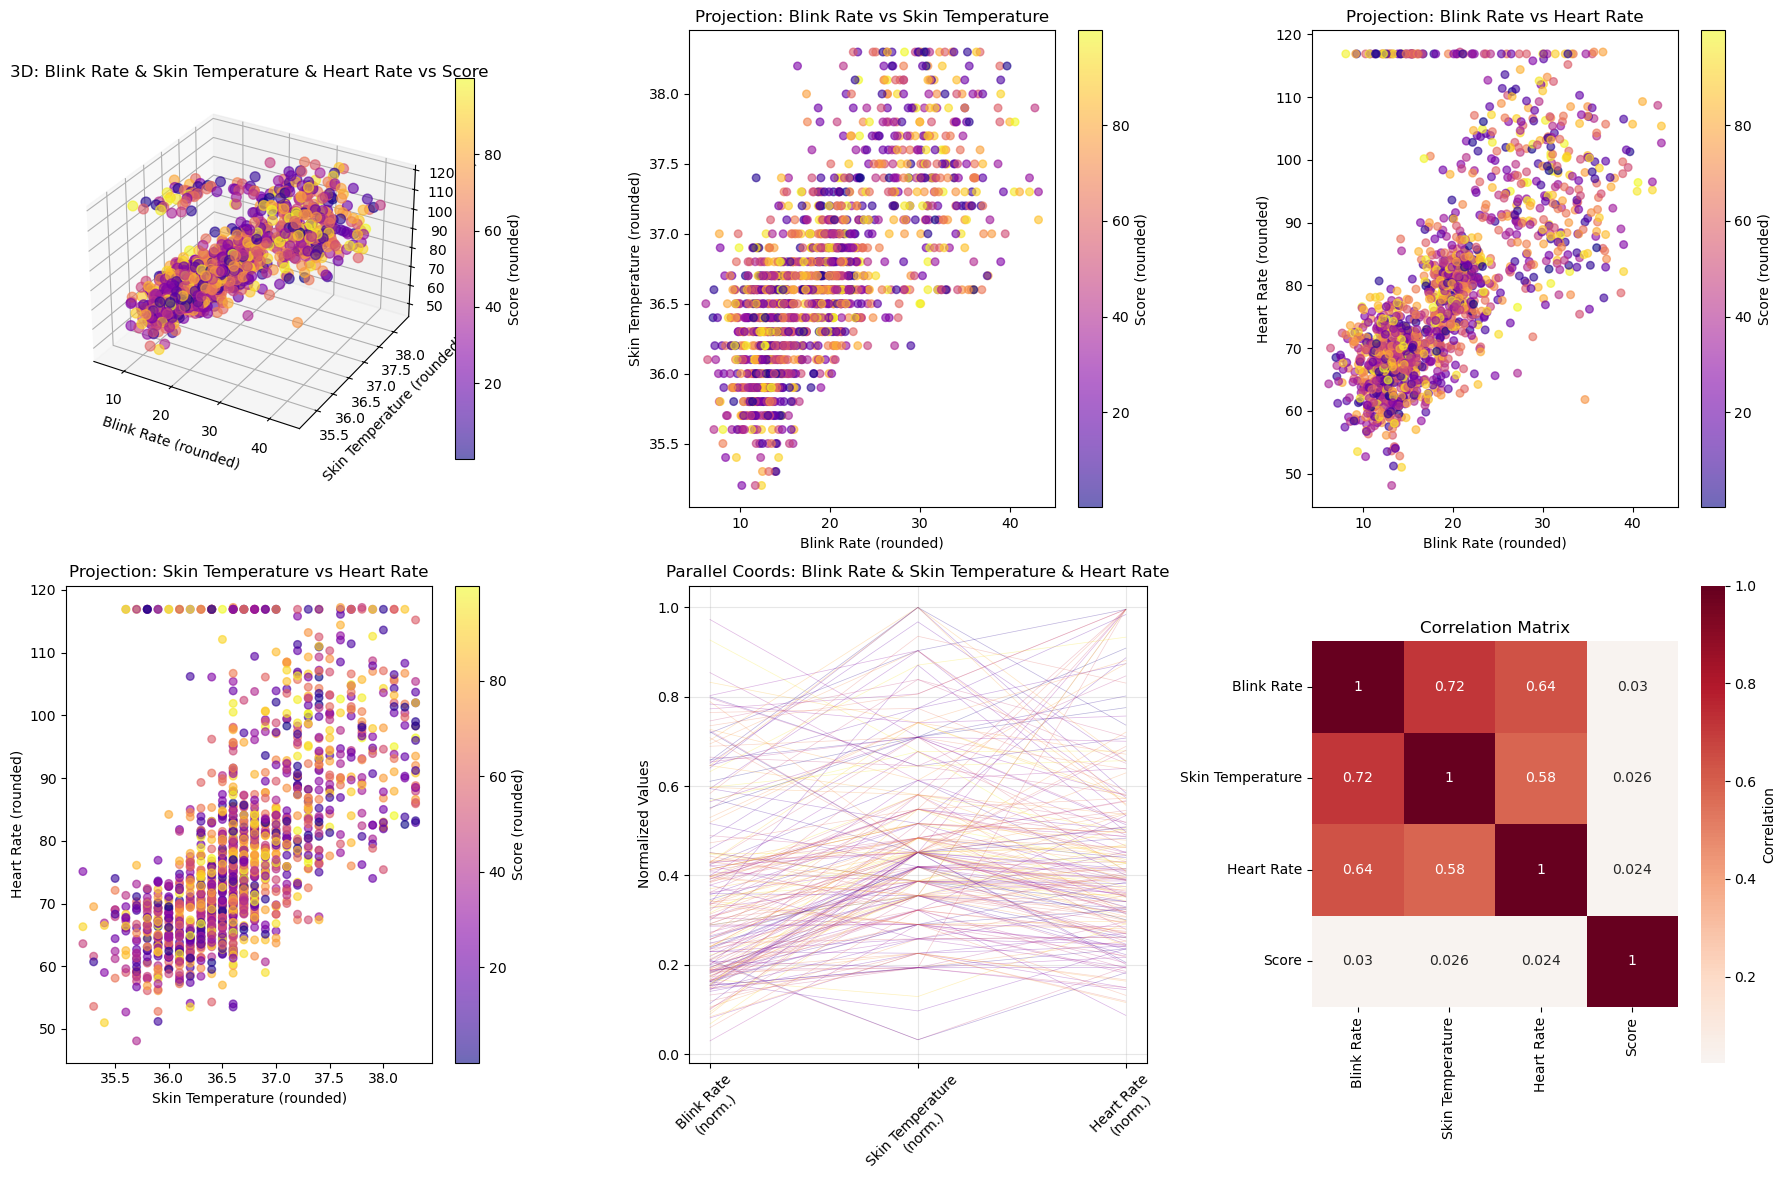


3. ALL FEATURES AGAINST SCORE


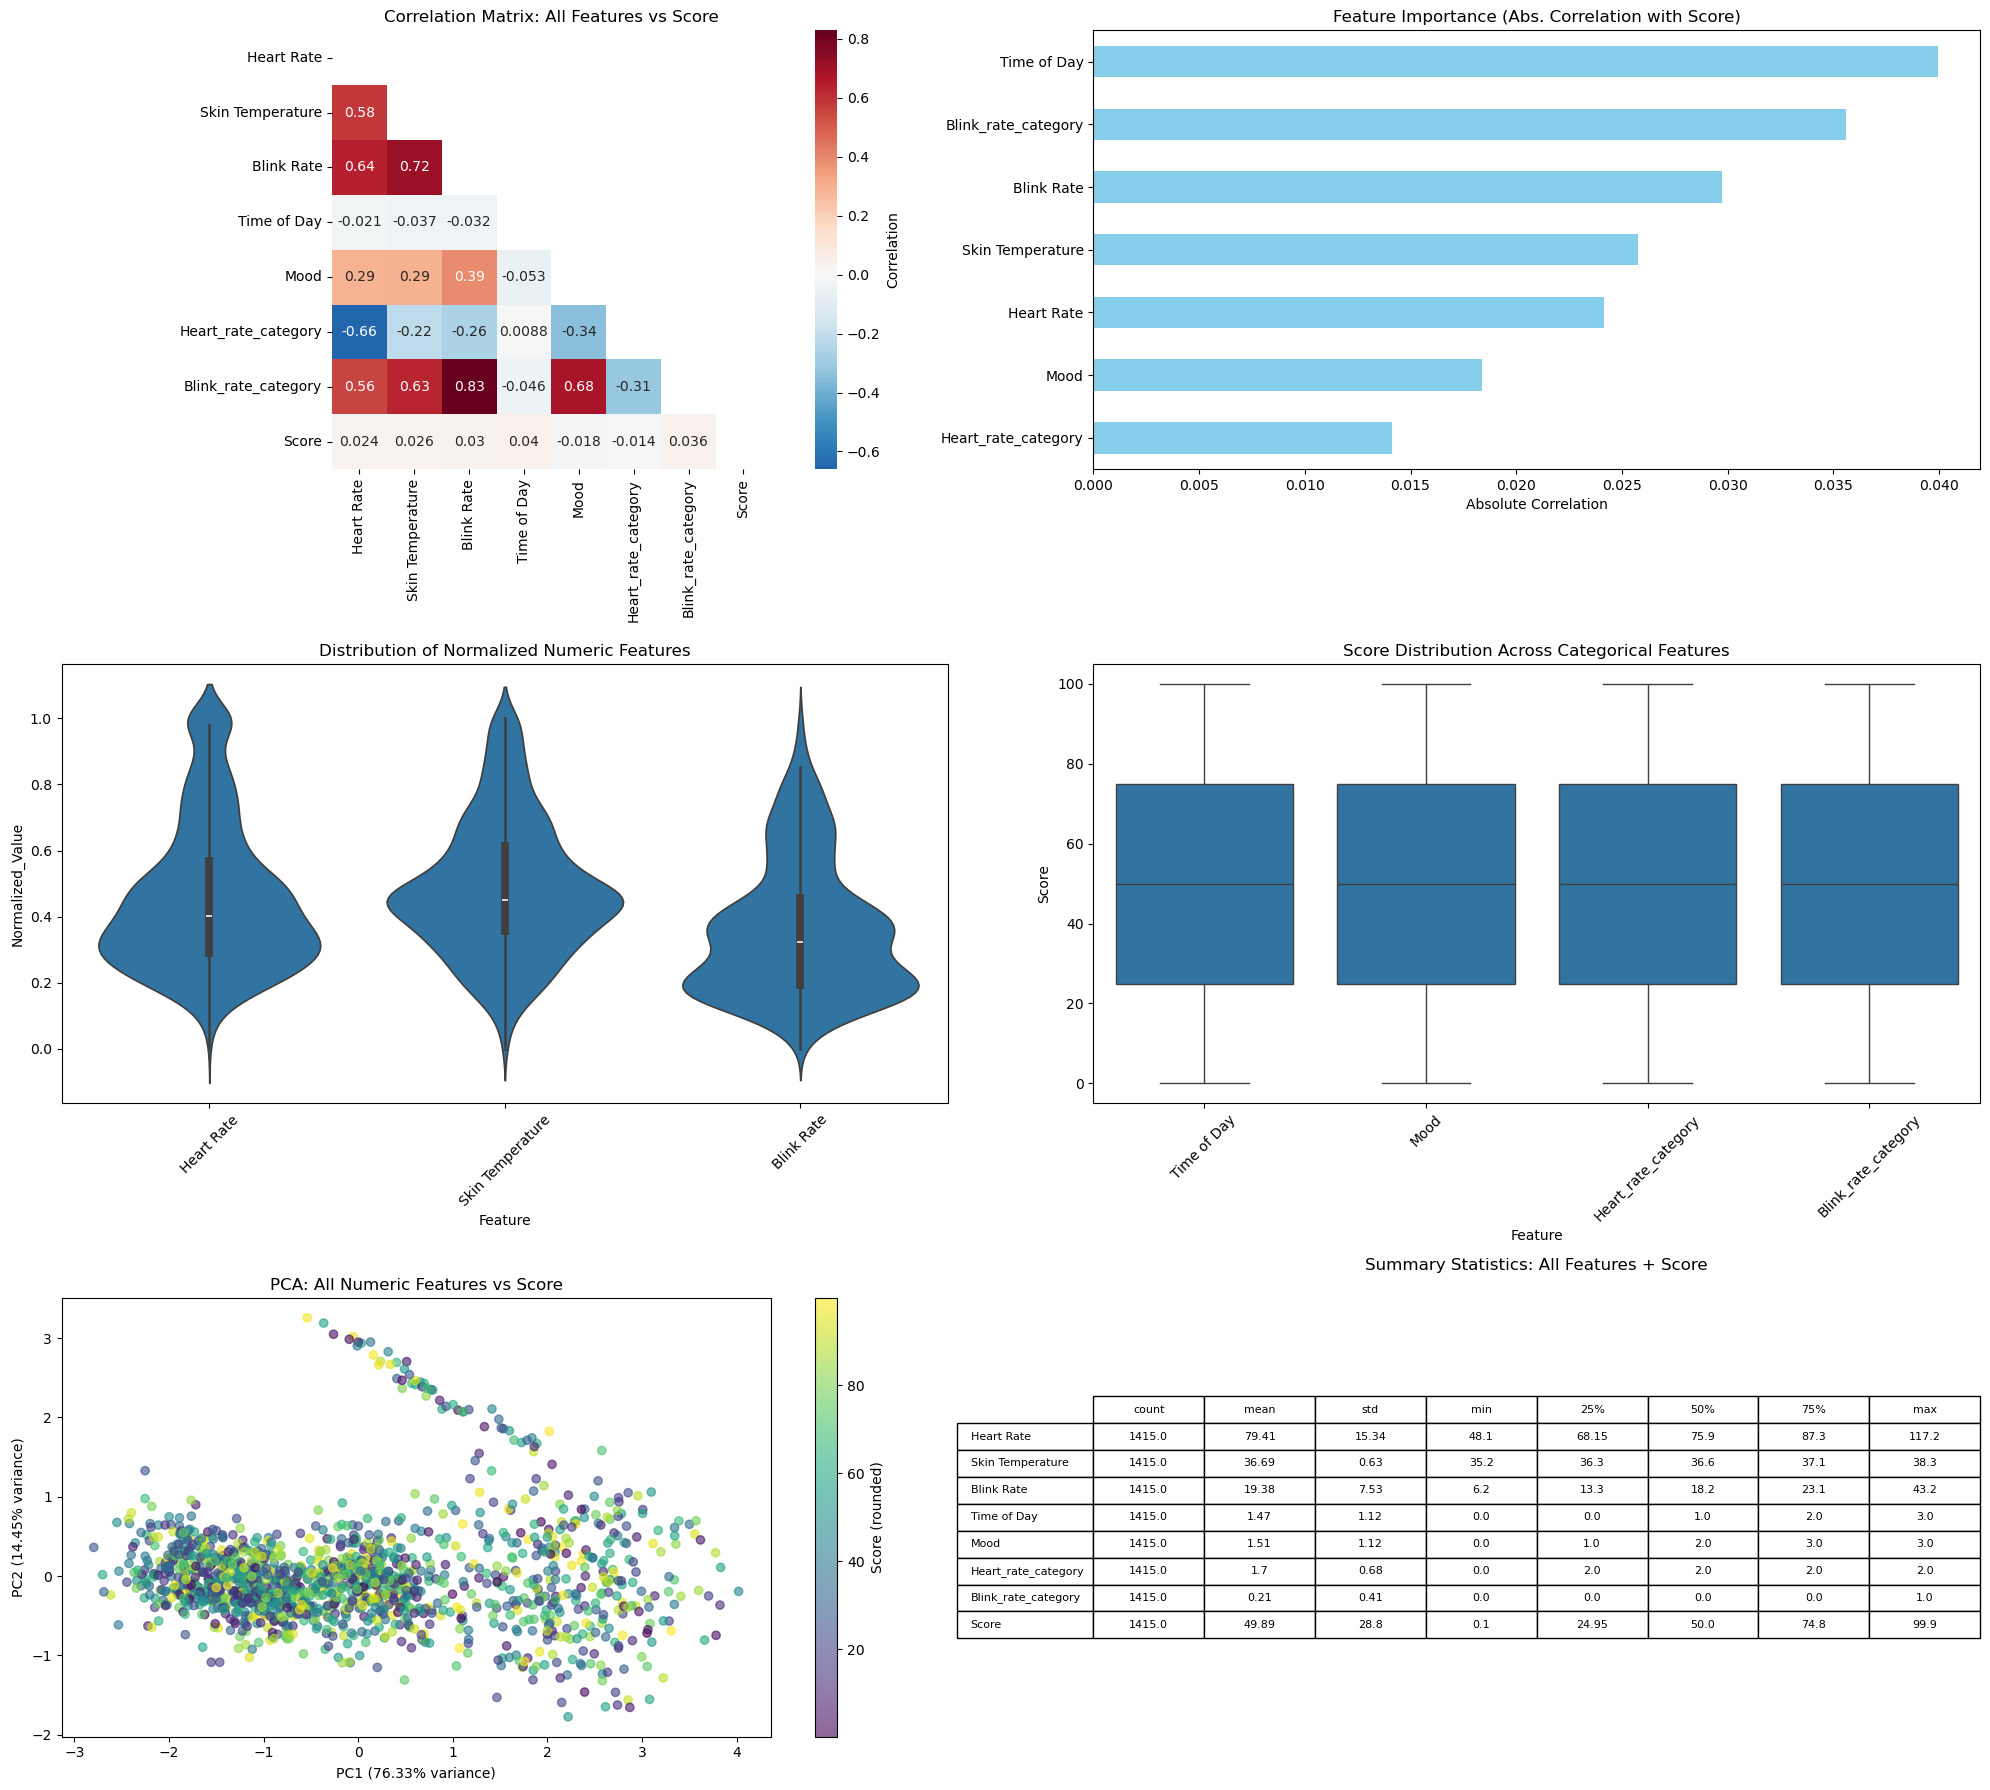


Summary:
- Total features analyzed: 7
- Numeric features: 3
- Categorical features: 4
- Top 3 features correlated with Score: ['Blink Rate', 'Skin Temperature', 'Heart Rate']


In [8]:
# Improved visualization of feature relationships with Score (all rounded to 1 decimal)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
import pandas as pd

target = "Score"
features = [col for col in data.columns if col != target]

# Round float columns (including Score) to 1 decimal place
float_cols = data.select_dtypes(include=["float"]).columns
data[float_cols] = data[float_cols].round(1)

# =============================================================================
# 1. PAIRWISE RELATIONSHIPS (At least 2 columns against Score)
# =============================================================================
print("=" * 60)
print("1. PAIRWISE RELATIONSHIPS WITH SCORE")
print("=" * 60)

# Get numeric features for better pairwise visualization
numeric_features = [col for col in features if data[col].dtype in ["int64", "float64"]]
categorical_features = [col for col in features if data[col].dtype not in ["int64", "float64"]]

# Create pairwise plots for numeric features
if len(numeric_features) >= 2:
    # Show top combinations based on correlation with target
    correlations = data[numeric_features + [target]].corr()[target].abs().sort_values(ascending=False)
    top_features = correlations.index[1:min(6, len(correlations))].tolist()  # Top 5 features (excluding target itself)
    
    for i, (feat1, feat2) in enumerate(combinations(top_features[:4], 2)):  # Limit to avoid too many plots
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Left plot: 3D-style scatter with color mapping
        scatter = axes[0].scatter(data[feat1], data[feat2], c=data[target], 
                                cmap='viridis', alpha=0.6, s=50)
        axes[0].set_xlabel(f"{feat1} (rounded)")
        axes[0].set_ylabel(f"{feat2} (rounded)")
        axes[0].set_title(f"2D: {feat1} & {feat2} vs {target}")
        plt.colorbar(scatter, ax=axes[0], label=f'{target} (rounded)')
        
        # Right plot: Contour plot showing Score density
        try:
            x = data[feat1]
            y = data[feat2]
            z = data[target]
            
            # Create grid for contour
            xi = np.linspace(x.min(), x.max(), 20)
            yi = np.linspace(y.min(), y.max(), 20)
            
            # Use hexbin for density
            hb = axes[1].hexbin(x, y, C=z, gridsize=15, cmap='RdYlBu', mincnt=1)
            axes[1].set_xlabel(f"{feat1} (rounded)")
            axes[1].set_ylabel(f"{feat2} (rounded)")
            axes[1].set_title(f"Density: {feat1} & {feat2} vs {target}")
            plt.colorbar(hb, ax=axes[1], label=f'{target} (rounded)')
        except:
            # Fallback to simple scatter
            axes[1].scatter(data[feat1], data[feat2], c=data[target], cmap='RdYlBu', alpha=0.6)
            axes[1].set_xlabel(f"{feat1} (rounded)")
            axes[1].set_ylabel(f"{feat2} (rounded)")
            axes[1].set_title(f"Fallback: {feat1} & {feat2} vs {target}")
        
        plt.tight_layout()
        plt.show()
        
        if i >= 2:  # Limit to 3 pairwise combinations
            break

# =============================================================================
# 2. TRIPLE RELATIONSHIPS (At least 3 columns against Score)
# =============================================================================
print("\n" + "=" * 60)
print("2. TRIPLE RELATIONSHIPS WITH SCORE")
print("=" * 60)

if len(numeric_features) >= 3:
    # Select top 3 features most correlated with Score
    top_3_features = correlations.index[1:4].tolist()
    
    fig = plt.figure(figsize=(18, 12))
    
    # 3D scatter plot
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    scatter = ax1.scatter(data[top_3_features[0]], data[top_3_features[1]], 
                         data[top_3_features[2]], c=data[target], cmap='plasma', s=50, alpha=0.6)
    ax1.set_xlabel(f"{top_3_features[0]} (rounded)")
    ax1.set_ylabel(f"{top_3_features[1]} (rounded)")
    ax1.set_zlabel(f"{top_3_features[2]} (rounded)")
    ax1.set_title(f"3D: {' & '.join(top_3_features)} vs {target}")
    plt.colorbar(scatter, ax=ax1, label=f'{target} (rounded)', shrink=0.8)
    
    # Pairwise projections with Score color-coding
    feature_pairs = [(0,1), (0,2), (1,2)]
    positions = [2, 3, 4]
    
    for idx, (i, j) in enumerate(feature_pairs):
        ax = fig.add_subplot(2, 3, positions[idx])
        scatter = ax.scatter(data[top_3_features[i]], data[top_3_features[j]], 
                           c=data[target], cmap='plasma', alpha=0.6, s=30)
        ax.set_xlabel(f"{top_3_features[i]} (rounded)")
        ax.set_ylabel(f"{top_3_features[j]} (rounded)")
        ax.set_title(f"Projection: {top_3_features[i]} vs {top_3_features[j]}")
        plt.colorbar(scatter, ax=ax, label=f'{target} (rounded)')
    
    # Parallel coordinates plot
    ax5 = fig.add_subplot(2, 3, 5)
    subset_data = data[top_3_features + [target]].copy()
    
    # Normalize data for parallel coordinates
    for col in subset_data.columns:
        subset_data[col] = (subset_data[col] - subset_data[col].min()) / (subset_data[col].max() - subset_data[col].min())
    
    # Sample data points to avoid overcrowding
    sample_size = min(200, len(subset_data))
    sampled_data = subset_data.sample(n=sample_size, random_state=42)
    
    for idx, row in sampled_data.iterrows():
        ax5.plot(range(len(top_3_features)), row[top_3_features], 
                color=plt.cm.plasma(row[target]), alpha=0.3, linewidth=0.5)
    
    ax5.set_xticks(range(len(top_3_features)))
    ax5.set_xticklabels([f"{feat}\n(norm.)" for feat in top_3_features], rotation=45)
    ax5.set_ylabel("Normalized Values")
    ax5.set_title(f"Parallel Coords: {' & '.join(top_3_features)}")
    ax5.grid(True, alpha=0.3)
    
    # Correlation heatmap
    ax6 = fig.add_subplot(2, 3, 6)
    corr_matrix = data[top_3_features + [target]].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, ax=ax6, 
                square=True, cbar_kws={'label': 'Correlation'})
    ax6.set_title(f"Correlation Matrix")
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# 3. ALL FEATURES AGAINST SCORE
# =============================================================================
print("\n" + "=" * 60)
print("3. ALL FEATURES AGAINST SCORE")
print("=" * 60)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# 1. Correlation heatmap of all features
ax1 = axes[0, 0]
all_corr = data[features + [target]].corr()
mask = np.triu(np.ones_like(all_corr, dtype=bool))
sns.heatmap(all_corr, mask=mask, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=ax1, cbar_kws={'label': 'Correlation'})
ax1.set_title("Correlation Matrix: All Features vs Score")

# 2. Feature importance plot (correlation with target)
ax2 = axes[0, 1]
feature_importance = data[features + [target]].corr()[target].abs().sort_values(ascending=True)
feature_importance = feature_importance[feature_importance.index != target]  # Remove target itself
feature_importance.plot(kind='barh', ax=ax2, color='skyblue')
ax2.set_title("Feature Importance (Abs. Correlation with Score)")
ax2.set_xlabel("Absolute Correlation")

# 3. Distribution of Score across all numeric features (violin plots)
ax3 = axes[1, 0]
if len(numeric_features) > 0:
    # Normalize features for comparison
    normalized_data = data[numeric_features].copy()
    for col in normalized_data.columns:
        normalized_data[col] = (normalized_data[col] - normalized_data[col].min()) / \
                              (normalized_data[col].max() - normalized_data[col].min())
    
    normalized_data[target] = data[target]
    melted_data = normalized_data.melt(id_vars=[target], var_name='Feature', value_name='Normalized_Value')
    
    sns.violinplot(data=melted_data, x='Feature', y='Normalized_Value', ax=ax3)
    ax3.set_title("Distribution of Normalized Numeric Features")
    ax3.tick_params(axis='x', rotation=45)

# 4. Score distribution across categorical features
ax4 = axes[1, 1]
if len(categorical_features) > 0:
    # Combine all categorical data
    cat_data_list = []
    for cat_feat in categorical_features:
        temp_df = data[[cat_feat, target]].copy()
        temp_df['Feature'] = cat_feat
        temp_df['Category'] = temp_df[cat_feat].astype(str)
        cat_data_list.append(temp_df[[target, 'Feature', 'Category']])
    
    if cat_data_list:
        combined_cat_data = pd.concat(cat_data_list, ignore_index=True)
        sns.boxplot(data=combined_cat_data, x='Feature', y=target, ax=ax4)
        ax4.set_title("Score Distribution Across Categorical Features")
        ax4.tick_params(axis='x', rotation=45)
else:
    ax4.text(0.5, 0.5, 'No Categorical Features Found', 
             horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)
    ax4.set_title("Categorical Features Analysis")

# 5. Principal Component Analysis view (if enough numeric features)
ax5 = axes[2, 0]
if len(numeric_features) >= 2:
    try:
        from sklearn.preprocessing import StandardScaler
        from sklearn.decomposition import PCA
        
        # Standardize features
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(data[numeric_features])
        
        # Apply PCA
        pca = PCA(n_components=2)
        pca_features = pca.fit_transform(scaled_features)
        
        scatter = ax5.scatter(pca_features[:, 0], pca_features[:, 1], 
                            c=data[target], cmap='viridis', alpha=0.6)
        ax5.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        ax5.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        ax5.set_title('PCA: All Numeric Features vs Score')
        plt.colorbar(scatter, ax=ax5, label=f'{target} (rounded)')
        
    except ImportError:
        ax5.text(0.5, 0.5, 'PCA requires sklearn\nShowing feature means instead', 
                horizontalalignment='center', verticalalignment='center', transform=ax5.transAxes)
        feature_means = data[numeric_features].mean().sort_values()
        feature_means.plot(kind='bar', ax=ax5)
        ax5.set_title('Mean Values of Numeric Features')
        ax5.tick_params(axis='x', rotation=45)
else:
    ax5.text(0.5, 0.5, 'Not enough numeric features for PCA', 
             horizontalalignment='center', verticalalignment='center', transform=ax5.transAxes)

# 6. Summary statistics table
ax6 = axes[2, 1]
ax6.axis('tight')
ax6.axis('off')

# Create summary statistics
summary_stats = data[features + [target]].describe().round(2)
table_data = summary_stats.transpose()

# Create table
table = ax6.table(cellText=table_data.values,
                 rowLabels=table_data.index,
                 colLabels=table_data.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
ax6.set_title("Summary Statistics: All Features + Score", pad=20)

plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"- Total features analyzed: {len(features)}")
print(f"- Numeric features: {len(numeric_features)}")
print(f"- Categorical features: {len(categorical_features)}")
print(f"- Top 3 features correlated with {target}: {correlations.index[1:4].tolist()}")

In [9]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import Font, PatternFill, Alignment
from openpyxl.utils import get_column_letter

# Target and features
target = "Score"
features = [col for col in data.columns if col != target]

# Round off all float columns (including Score) to 1 decimal
float_cols = data.select_dtypes(include=["float"]).columns
data[float_cols] = data[float_cols].round(1)

# Output file
output_file = "feature_score_summary.xlsx"

# Create Excel writer
with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    for col in features:
        # Build summary table
        table = (
            data.groupby([col, target])
            .size()
            .reset_index(name="Count")
            .sort_values([col, target])
        )
        
        # Write each feature into a separate sheet
        sheet_name = col[:30]  # Excel allows max 31 chars
        table.to_excel(writer, sheet_name=sheet_name, index=False)

# Apply formatting
wb = load_workbook(output_file)
for sheet in wb.sheetnames:
    ws = wb[sheet]
    
    # Style header row
    for cell in ws[1]:
        cell.font = Font(bold=True, color="FFFFFF")
        cell.fill = PatternFill(start_color="4F81BD", end_color="4F81BD", fill_type="solid")
        cell.alignment = Alignment(horizontal="center", vertical="center")
    
    # Auto-adjust column width
    for col in ws.columns:
        max_length = max(len(str(cell.value)) if cell.value is not None else 0 for cell in col)
        ws.column_dimensions[get_column_letter(col[0].column)].width = max_length + 2

wb.save(output_file)
print(f"✅ Feature vs Score summary saved to '{output_file}' with one sheet per column (rounded to 1 decimal).")


✅ Feature vs Score summary saved to 'feature_score_summary.xlsx' with one sheet per column (rounded to 1 decimal).


In [10]:
data

,Heart Rate,Skin Temperature,Blink Rate,Time of Day,Mood,Score,Heart_rate_category,Blink_rate_category
0,72.8,36.7,19.0,3,0,8.0,2,0
1,69.5,35.6,11.6,2,2,24.2,2,0
2,98.0,38.0,34.7,0,3,77.4,2,1
3,72.7,36.7,21.0,1,0,52.9,2,0
4,70.3,35.9,10.2,0,2,92.8,2,0
...,...,...,...,...,...,...,...,...
1495,75.9,37.1,23.8,0,0,92.8,2,0
1496,111.3,37.2,27.0,1,3,9.4,0,1
1497,62.1,35.7,8.5,1,2,37.1,2,0
1498,84.5,36.2,21.3,0,0,70.9,2,0
